<a href="https://colab.research.google.com/github/eduvaladao/aulas_escola_cbpf_XIII/blob/main/aula03_XIII_Escola_do_CBPF_Power_Spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://farm66.staticflickr.com/65535/49055715328_092031af74_o.png"  width="150" />

<font size="5"> Power Spectrum from Simulations
    
<font size="2">
    
This notebook was developed by Tiago Castro, Clecio R. Bom for the XIII CBPF School (2021)- Introduction to Cosmology with python (Curso de Introdução a Cosmologia com Python) prof. Clécio R. Bom
<a href="www.clearnightsrthebest.com">clearnightsrthebest.com</a>
    
**Contact:** debom@cbpf.br</font>

<font size="2">

Please do not remove this disclaimer.</font>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import binned_statistic
from numba import njit, jit
import pyccl as ccl

In [ ]:
# Pick a redshift from the list of outputs
redshift = 2.1844

In [ ]:
# Create new Cosmology object with a given set of parameters. This keeps track
# of previously-computed cosmological functions
cosmo_l = ccl.Cosmology(
    Omega_c=0.272*(1.0-0.168), Omega_b=0.272*0.168, h=0.704, sigma8=0.809, n_s=0.963, matter_power_spectrum='linear')

cosmo_nl = ccl.Cosmology(
    Omega_c=0.272*(1.0-0.168), Omega_b=0.272*0.168, h=0.704, sigma8=0.809, n_s=0.963)

# Define a simple binned galaxy number density curve as a function of redshift
z_n = np.linspace(0., redshift, 200)
n = np.zeros(z_n.shape); n[-1] = 1

# Create objects to represent tracers of the weak lensing signal
lens = ccl.WeakLensingTracer(cosmo, dndz=(z_n, n))

# Calculate the angular cross-spectrum of the two tracers as a function of ell
ell = np.arange(2, 100000)
cls_l  = ccl.angular_cl(cosmo_l, lens, lens, ell)
cls_nl = ccl.angular_cl(cosmo_nl, lens, lens, ell)

In [ ]:
# Compute the Cl of a map
def PS (field, size):

    # Taking the fourier transform
    kx = 2 * np.pi * np.fft.fftfreq(field.shape[0], size/field.shape[0])
    ky = 2 * np.pi * np.fft.fftfreq(field.shape[1], size/field.shape[1])
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K = np.sqrt(KX**2 + KY**2).flatten()

    kf   = np.min([ KX[1,0], KY[0,1] ])
    bins = np.array([i*kf for i in range(field.shape[0])])

    P = np.fft.fft2( field ); P = P.flatten()
    P = np.real(P * np.conj(P))

    P = binned_statistic(K, P, bins=bins, statistic='mean').statistic
    K = binned_statistic(K, K, bins=bins, statistic='mean').statistic

    # Normalization
    bin_width1 = 2*np.pi/KX[1,0]/KX.shape[0]
    bin_width2 = 2*np.pi/KY[0,1]/KY.shape[1]
    N = bin_width1*bin_width2/KX.shape[0]/KX.shape[1]

    return np.transpose( [K, N*P] )

# Lowering resolution of the map
@jit(nopython=True)
def average_filter (field, field_lr):
    
    for i in range(field_lr.shape[0]):

        for j in range(field_lr.shape[1]):

            field_lr[i,j]  = (field[2*i,2*j] + field[2*i+1, 2*j] + field[2*i, 2*j+1] + field[2*i+1,2*j+1])/4

In [ ]:
kappa  = fits.getdata("gadget_z{}_kappa.fits".format(redshift)).astype(np.float32)
header = fits.getheader("gadget_z{}_kappa.fits".format(redshift))
size   = header['ANGLE'] * np.pi / 180.0

In [ ]:
# Creating a lower resolution map to faster computation
kappa_lr = np.empty( (kappa.shape[0]//2, kappa.shape[0]//2), dtype=np.float32)
average_filter(kappa, kappa_lr)

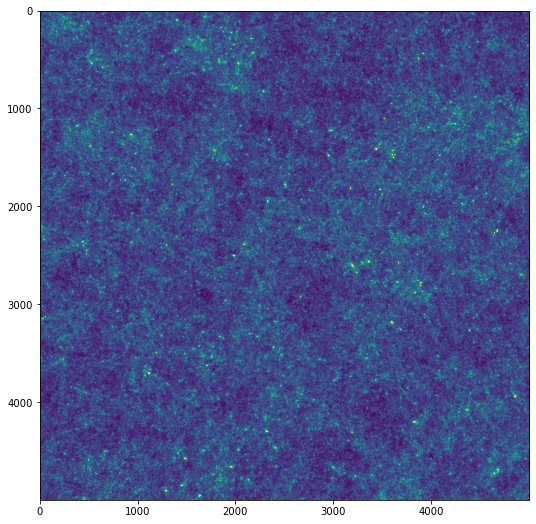

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(kappa_lr, vmin=np.quantile(kappa_lr.flatten(), 0.003), vmax=np.quantile(kappa_lr.flatten(), 0.997))

In [ ]:
l, Cl = PS(kappa_lr, size).T

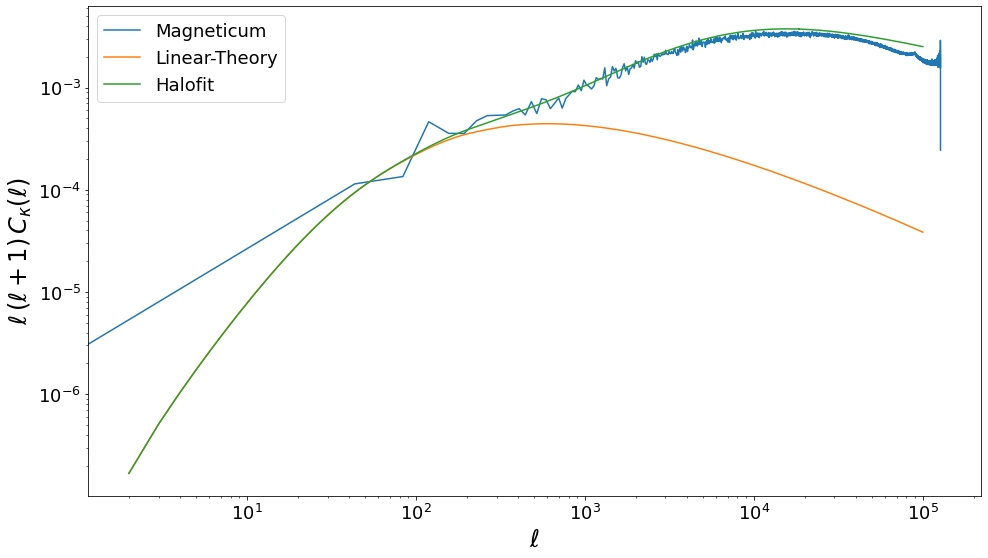

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.loglog(l, l*(l+1)*Cl, label='Magneticum')
ax.loglog(ell, ell*(ell+1)*cls_l, label='Linear-Theory')
ax.loglog(ell, ell*(ell+1)*cls_nl, label='Halofit')
ax.set_xlabel(r'$\ell$', size=24)
ax.set_ylabel(r'$\ell\,(\ell+1)\,C_{\kappa}(\ell)$', size=24)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=18)